#### Fardin Rastakhiz @2023

In [9]:
from scripts.graph_constructors.GraphConstructor import TextGraphType
import os
from scripts.graph_data_modules.AGGraphDataModule import AGGraphDataModule
import torch
from torch.utils.flop_counter import FlopCounterMode
from scripts.configs.ConfigClass import Config

config = Config(r'C:\Users\fardin\Projects\BeyondWordsSimplified')
# config = Config(r'E:\Darsi\Payan Name Arshad\Second Work\ColorIntelligence2\ColorIntelligence')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256


In [10]:
# from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding4 import HeteroDeepGraphEmbedding4
# from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding5 import HeteroDeepGraphEmbedding5
# from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding6 import HeteroDeepGraphEmbedding6
from scripts.models.HeteroDeepGraphEmbedding8 import HeteroDeepGraphEmbedding8

In [11]:
from scripts.lightnings.LightningModels import HeteroMultiClassLightningModel
from scripts.loss_functions.HeteroLossFunctions import MulticlassHeteroLoss1, MulticlassHeteroLoss2, MulticlassHeteroLoss3
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import lightning as L
from lightning.pytorch.tuner import Tuner
from scripts.managers.ClassifierModelManager import ClassifierModelManager

In [15]:
graph_type = TextGraphType.SEQUENTIAL
data_manager = AGGraphDataModule(config, test_size=0.00, val_size=0.05511811, shuffle=False, start_data_load=0 , end_data_load = 7000 , device='cpu', batch_size=batch_size, graph_type=graph_type, load_preprocessed_data = False)
data_manager.load_labels()
data_manager.load_graphs()

 Creating Graphs : 100%|██████████| 7000/7000 [02:15<00:00, 51.59it/s]


filename: C:\Users\fardin\Projects\BeyondWordsSimplified\data/GraphData/AG\seq_gen\graph_var.txt


 Loding Graphs From File : 100%|██████████| 7/7 [00:30<00:00,  4.40s/it]


In [13]:
# data_manager.update_batch_size(256)

In [99]:
val_dataloader = data_manager.val_dataloader()
X3, Y3 = next(iter(val_dataloader))

In [102]:
from copy import copy
metadata = copy(X3.metadata())

In [19]:

edge_type_weights = {
    # 'full': [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
    # 'full-non-sentiment': [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
    'seq': [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    # 'dep': [1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    # 'tag': [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
    # 'general_sentence': [0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
    # 'sentence': [0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
    # 'sentiment': [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
}
# type_checkpoint = {
#     #  'dep': r'logs\hetero_model_14_AG\version_0\checkpoints\epoch=38-step=17199.ckpt',
#      'tag': r'logs\hetero_model_15_AG_tag\version_0\checkpoints\epoch=9-step=4410.ckpt',
#      'general_sentence': '',
#      'sentence': '',
# }

In [20]:
# edge_type_weights = {
#     'seq_gen': [1, 1, 1],
#     'seq': [0, 0, 1]
# }
# type_checkpoint = {
#     'seq_gen': r'logs\hetero_model_12_AG\version_1\checkpoints\epoch=24-step=11025.ckpt',
#     'seq': r'logs\hetero_model_12_AG\version_2\checkpoints\epoch=22-step=10143.ckpt'
# }

In [103]:
from os import path
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss
import torchmetrics

def save_evaluation(model_mgr, eval_dataloader, name_prepend: str='',
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False,
                 multi_class: bool=False
                 ):
        
        test_metrics_path = path.join(model_mgr.log_dir, model_mgr.log_name, f'version_{model_mgr.logger.version}', f'{name_prepend}_test_metrics.txt')
        
        y_true = []
        y_pred = []
        model_mgr.lightning_model.eval()
        model_mgr.lightning_model.model.eval()
        model_mgr.torch_model.eval()
        for X, y in eval_dataloader:
            model_mgr.trainer.model.eval()
            with torch.no_grad():
                y_p = model_mgr.trainer.model(X.to(model_mgr.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            
            if multi_class:
                y_pred.append(y_p.detach().to(y.device))
                y_true.append(y)
            else:
                y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        print(y_true.shape)
        print(y_pred.shape)
        if multi_class:
            y_true_num = torch.argmax(y_true, dim=1)
            y_pred_num = torch.argmax(y_pred, dim=1)
        else:
            y_true_num = y_true
            y_pred_num = y_pred
            
        print(y_true_num.shape)
        print(y_pred_num.shape)
        with open(test_metrics_path, 'at+') as f:
            if(give_confusion_matrix):
                print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
            if(give_report):
                print(classification_report(y_true_num, y_pred_num), file=f)
            if(give_f1_score):
                if multi_class:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
            if(give_accuracy_score):
                print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
            if(give_precision_score):
                if multi_class:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num)}', file=f)
            if(give_recall_score):
                if multi_class:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num)}', file=f)
            if(give_hinge_loss):
                print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)


In [104]:
for k in edge_type_weights:
    graph_embedding = HeteroDeepGraphEmbedding8(300, 4, metadata, 32, dropout=0.2, edge_type_count=1, edge_type_weights=edge_type_weights[k], active_keys = ['word'])
    graph_embedding = graph_embedding.to(device)
    # callbacks = [
    # ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
    # ]
    
    
    # loss_func = MulticlassHeteroLoss2(exception_keys=['word'], enc_factor=0.0002)
    # optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.0045, weight_decay=0.0012)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 20, 35], gamma=0.6, verbose=True)
    # lightning_model = HeteroMultiClassLightningModel(graph_embedding, 4,
    #                                     optimizer=optimizer,
    #                                     loss_func=loss_func,
    #                                     learning_rate=0.0045,
    #                                     batch_size=batch_size,
    #                                     user_lr_scheduler=True,
    #                                     lr_scheduler=lr_scheduler,
    #                                     min_lr=0.0005
    #                                     ).to(device)
    # lightning_model.model.to(device)
          
    # model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_18_AG',device=device, num_train_epoch=70)
    flopt_counter = FlopCounterMode(graph_embedding)
    with flopt_counter:
        graph_embedding(X3.to(device))
    # model_manager.draw_summary(data_manager.val_dataloader())
    # model_manager.fit(datamodule=data_manager, ckpt_path=r'logs\hetero_model_18_AG\version_8\checkpoints\epoch=38-step=18252.ckpt')
    
    # model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
    # model_manager.torch_model = model_manager.torch_model.to(device)
    # save_evaluation(model_manager, data_manager.val_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)

c:\Users\fardin\Projects\BeyondWordsSimplified\scripts\models\HeteroDeepGraphEmbedding8.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)


Module                                           FLOP    % Total
------------------------------------------  ---------  ---------
HeteroDeepGraphEmbedding8                   1281.396M    100.00%
 - aten.addmm                               1232.074M     96.15%
 - aten.mm                                    34.941M      2.73%
 - aten.convolution                            0.095M      0.01%
 - aten.bmm                                   14.285M      1.11%
 HeteroDeepGraphEmbedding8.hetero_linear1    224.429M     17.51%
  - aten.addmm                               224.429M     17.51%
 HeteroDeepGraphEmbedding8.hetero_gat_1       97.602M      7.62%
  - aten.addmm                                94.708M      7.39%
  - aten.mm                                    2.894M      0.23%
 HeteroDeepGraphEmbedding8.hetero_linear_2    23.939M      1.87%
  - aten.addmm                                23.939M      1.87%
 HeteroDeepGraphEmbedding8.hetero_gat_2      915.017M     71.41%
  - aten.addmm           

In [113]:
import torch.nn.functional as F
from torch import Tensor
import torch
from torch.nn import Linear
from torch_geometric.nn import BatchNorm, MemPooling, to_hetero, PairNorm
from torch_geometric.data import HeteroData
from scripts.models.base_models.HeteroGat import HeteroGat
from scripts.models.base_models.HeteroLinear import HeteroLinear

class HeteroDeepGraphEmbedding6(torch.nn.Module):
    
    def __init__(self,
                 input_feature: int, out_features: int,
                 metadata,
                 hidden_feature: int=256,
                 device = 'cpu',
                 dropout=0.1,
                 edge_type_count=9,
                 edge_type_weights=-1,
                 active_keys = ['word', 'general'],
                 num_pooling_classes=1
                 ):

        super(HeteroDeepGraphEmbedding6, self).__init__()
        self.input_features = input_feature
        self.num_out_features = out_features
        self.hidden_feature: int = hidden_feature
        self.edge_type_count = edge_type_count
        self.edge_type_weights = torch.nn.Parameter(torch.tensor([1]* self.edge_type_count if edge_type_weights==-1 else  edge_type_weights).to(torch.float32), requires_grad=False)

        self.part_weight_norm = torch.nn.LayerNorm((self.edge_type_count,))
        self.norm = PairNorm()
        self.drop = torch.nn.Dropout(0.2)
        self.active_keys = active_keys
        
        self.hetero_linear1 = to_hetero(HeteroLinear(self.input_features,self.hidden_feature, use_dropout=False, use_batch_norm=True), metadata)
        
        self.hetero_gat_1 = to_hetero(HeteroGat(self.hidden_feature, self.hidden_feature, dropout, num_heads=2), metadata)
        self.hetero_gat_2 = to_hetero(HeteroGat(self.hidden_feature, self.hidden_feature, dropout, num_heads=2), metadata)
        
        self.hetero_linear_2 = to_hetero(HeteroLinear(self.hidden_feature, self.input_features, dropout, use_batch_norm=True), metadata)
        
        self.num_pooling_classes = torch.nn.Parameter(torch.tensor(num_pooling_classes).to(torch.int32), requires_grad=False)
        self.mem_pool = MemPooling(self.hidden_feature, self.hidden_feature, 2, self.num_pooling_classes)
        
        self.linear_1 = Linear(self.hidden_feature* self.num_pooling_classes, self.hidden_feature)
        self.linear_2 = Linear(self.hidden_feature, self.hidden_feature)
        self.batch_norm_1 = BatchNorm(self.hidden_feature)
        
        self.output_layer = Linear(self.hidden_feature, self.num_out_features)
        
        self.dep_embedding = torch.nn.Embedding(45, self.input_features)
        self.tag_embedding = torch.nn.Embedding(50, self.input_features)
        self.dep_unembedding = torch.nn.Linear(self.hidden_feature, 45)
        self.tag_unembedding = torch.nn.Linear(self.hidden_feature, 50)
        
        self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
        
        self.x_batches = None
        self.x_batches_cpu = None
        self.x_dict_cpu_1 = None
        self.x_dict_cpu_2 = None
        

    def forward(self, x: HeteroData) -> Tensor:
        self.x_batches = {k:x[k].batch for k in self.active_keys}
        # self.x_batches_cpu = {k:self.x_batches[k].to('cpu') for k in self.active_keys}
        x_dict, edge_attr_dict, edge_index_dict = self.preprocess_data(x)
        edge_attr_dict = self.update_weights(edge_attr_dict, self.pw1)
        x_dict = self.hetero_linear1(x_dict)
        x_dict = self.hetero_gat_1(x_dict, edge_index_dict, edge_attr_dict)
        # self.x_dict_cpu_1 = {k: x_dict[k].to('cpu') for k in x_dict}
        self.normalize(x_dict, self.x_batches)
        x_dict = self.hetero_gat_2(x_dict, edge_index_dict, edge_attr_dict)
        # self.x_dict_cpu_2 = {k: x_dict[k].to('cpu') for k in x_dict}
        x_pooled, S = self.mem_pool(x_dict['word'], self.x_batches['word'])
                
        x_pooled = x_pooled.view(x_pooled.shape[0], -1)
        x_pooled = F.relu(self.linear_1(x_pooled))
        x_pooled = F.relu(self.batch_norm_1(self.linear_2(x_pooled)))
        out = self.output_layer(x_pooled)
        
        x_dict_out = self.hetero_linear_2(x_dict)
        if 'dep' in x_dict:
            x_dict_out['dep'] = self.dep_unembedding(x_dict['dep'])
        if 'tag' in x_dict:
            x_dict_out['tag'] = self.tag_unembedding(x_dict['tag'])
        
        return out, x_dict_out

    def preprocess_data(self, x):
        x_dict = {key: x.x_dict[key] for key in x.x_dict}
        if 'dep' in x_dict:
            x_dict['dep'] = self.dep_embedding(x_dict['dep'])
        if 'tag' in x_dict:
            x_dict['tag'] = self.tag_embedding(x_dict['tag'])

        edge_attr_dict = x.edge_attr_dict
        edge_index_dict = x.edge_index_dict

        return x_dict, edge_attr_dict, edge_index_dict

    def normalize(self, x_dict, x_batches):
        for k in self.active_keys:
            vecs = x_dict[k]
            if k not in x_batches:
                print('k is not in x_batches')
                continue
            batches = x_batches[k]
            if batches is None:
                print('batches is none')
                continue
            if len(batches) == 0:
                print('batches is empty')
                continue
            
            x_dict[k] = self.norm(vecs, batches)
        return x_dict

    def update_weights(self, edge_attr_dict, part_weights):
        for i, key in enumerate(edge_attr_dict):
            edge_attr = edge_attr_dict[key]
            if edge_attr is None or edge_attr == ('word', 'seq', 'word'):
                continue
            edge_attr_dict[key]= edge_attr * part_weights[i]
        return edge_attr_dict

    def get_scale_same(self, scale:float, attributes: Tensor):
        if attributes is None or len(attributes) == 0:
            return
        attributes = scale * torch.ones_like(attributes)
        return attributes

In [114]:
from typing import List
import torch
from torch import nn

from scripts.loss_functions.HeteroLossArgs import HeteroLossArgs

class MulticlassHeteroLoss2(torch.nn.Module):
    def __init__(self, exception_keys: List[str], enc_factor=0.0, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.cel_loss=  torch.nn.CrossEntropyLoss()
        self.mse_loss = torch.nn.MSELoss()
        self.exception_keys = exception_keys
        self.enc_factor = enc_factor
    
    def forward(self, out_pred: HeteroLossArgs, out_main: HeteroLossArgs):
        loss = self.cel_loss(out_pred.y, out_main.y)
        x_dict_keys = [k for k in out_pred.x_dict.keys() if k not in self.exception_keys]
        
        for key in x_dict_keys:
            tensor1 = out_pred.x_dict[key]
            tensor2 = out_main.x_dict[key]
            if tensor2.ndim == 1 and tensor2.dtype is torch.long:
                tensor2 = torch.nn.functional.one_hot(input=tensor2.to(torch.long), num_classes=tensor1.shape[1]).to(torch.float32)
            loss += self.enc_factor * (self.mse_loss(tensor1, tensor2))
        return loss

In [115]:
# Fardin Rastakhiz @ 2023
from torch import nn, Tensor
import torch.nn.functional as F
from torch_geometric.nn import BatchNorm

class HeteroLinear(nn.Module):
    
    def __init__(self, in_feature, out_feature, dropout = 0.2, use_dropout=True, use_batch_norm=False, use_activation=True) -> None:
        super().__init__()
        self.linear = nn.Linear(in_feature, out_feature)
        self.batch_norm = BatchNorm(out_feature)
        self.dropout= nn.Dropout(dropout)
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        self.use_activation=use_activation

    def forward(self, x: Tensor) -> Tensor:

        x = self.linear(x)
        if self.use_batch_norm:
            x = self.batch_norm(x)
        if self.use_activation:
            x = F.leaky_relu(x)
        if self.use_dropout:
            x = self.dropout(x)
        return x

In [108]:
X, y = next(iter(data_manager.val_dataloader()))

In [116]:
graph_embedding = HeteroDeepGraphEmbedding6(300, 4, metadata, 32, dropout=0.1, edge_type_count=1, edge_type_weights=edge_type_weights[k], active_keys=['word', 'general'])

C:\Users\fardin\AppData\Local\Temp\ipykernel_22276\2245926672.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)


In [117]:
y_pred = graph_embedding(X)

C:\Users\fardin\AppData\Local\Temp\ipykernel_22276\2245926672.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Adjusting learning rate of group 0 to 4.5000e-03.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 89.0 K
1 | loss_func | MulticlassHeteroLoss2     | 0     
2 | train_acc | MulticlassAccuracy        | 0     
3 | val_acc   | MulticlassAccuracy        | 0     
4 | test_acc  | MulticlassAccuracy        | 0     
--------------------------------------------------------
88.9 K    Trainable params
23        Non-trainable params
89.0 K    Total params
0.356     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-package

Epoch 18:  88%|████████▊ | 22/25 [00:06<00:00,  3.66it/s, v_num=5, train_loss_step=0.145, train_acc_step=0.969, val_acc=0.842, train_loss_epoch=0.214, train_acc_epoch=0.933]

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


torch.Size([386, 4])
torch.Size([386, 4])
torch.Size([386])
torch.Size([386])


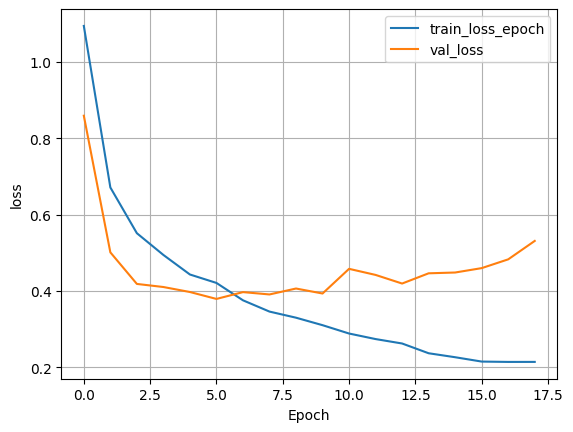

In [118]:
for i in range(1):
    for k in edge_type_weights:
        graph_embedding = HeteroDeepGraphEmbedding6(300, 4, metadata, 32, dropout=0.1, edge_type_count=1, edge_type_weights=edge_type_weights[k], active_keys=['word', 'general'])
        graph_embedding = graph_embedding.to(device)
        callbacks = [
        ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
        ]
        loss_func = MulticlassHeteroLoss2(exception_keys=['word'], enc_factor=0.0003)
        optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.0045, weight_decay=0.00125)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6, 13, 28, 45, 60], gamma=0.5, verbose=True)
        lightning_model = HeteroMultiClassLightningModel(graph_embedding, 4,
                                            optimizer=optimizer,
                                            loss_func=loss_func,
                                            learning_rate=0.045,
                                            batch_size=batch_size,
                                            user_lr_scheduler=True,
                                            lr_scheduler=lr_scheduler,
                                            min_lr=0.0005
                                            ).to(device)
        lightning_model.model.to(device)
            
        model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_20_AG',device=device, num_train_epoch=70)
        model_manager.fit(datamodule=data_manager)
        model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{i}_{k}')
        model_manager.torch_model = model_manager.torch_model.to(device)
        save_evaluation(model_manager, data_manager.val_dataloader(), f'{i}_{k}',True, True, True, True, True, True, True, multi_class=True)